## Project Overview
- **Goal:** Predict aqueous solubility (logS) of molecules using their graph structure.
- **Dataset:** ESOL
- **Techniques:** Graph Neural Networks (GCN), PyTorch Geometric, RDKit for visualization
- **Author:** Abhyudaya Tak

## 1. Load and Explore the ESOL Dataset

In [17]:
from torch_geometric.datasets import MoleculeNet
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
import seaborn as sns

# Load ESOL dataset
DATA = MoleculeNet(root=".", name="ESOL")

# Convert to DataFrame for summary
raw_csv = pd.read_csv("./esol/raw/delaney-processed.csv")
display(raw_csv.head())

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [18]:
print("Dataset type: ", type(DATA))
print("Number of features per graph node: ", DATA.num_features)
print("Number of distinct target values (solubilities): ", DATA.num_classes)
print("Number of graphs: ", len(DATA))
print("Example graph: ", DATA[0])
print("Number of nodes in example graph: ", DATA[0].num_nodes)
print("Number of edges in example graph: ", DATA[0].num_edges)

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Number of features per graph node:  9
Number of distinct target values (solubilities):  734
Number of graphs:  1128
Example graph:  Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
Number of nodes in example graph:  32
Number of edges in example graph:  68


In [19]:
# nodes of example graph 
DATA[0].x # shape: [num_nodes, num_node_features]

tensor([[8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 0],
        [6, 0, 2, 5, 0, 0, 2, 0, 0],
        [7, 0, 1, 5, 0, 0, 2, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
 

In [20]:
# the target value of the example graph is its solubility
DATA[0].y

tensor([[-0.7700]])

In [21]:
# the edges of the example graph are in sparse Coordinate Format (COO)
# (also called adjacency list: https://distill.pub/2021/gnn-intro/
DATA[0].edge_index.t() # shape [num_edges, 2]

tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 2,  1],
        [ 2,  3],
        [ 2, 30],
        [ 3,  2],
        [ 3,  4],
        [ 4,  3],
        [ 4,  5],
        [ 4, 26],
        [ 5,  4],
        [ 5,  6],
        [ 6,  5],
        [ 6,  7],
        [ 7,  6],
        [ 7,  8],
        [ 7, 24],
        [ 8,  7],
        [ 8,  9],
        [ 9,  8],
        [ 9, 10],
        [ 9, 20],
        [10,  9],
        [10, 11],
        [11, 10],
        [11, 12],
        [11, 14],
        [12, 11],
        [12, 13],
        [13, 12],
        [14, 11],
        [14, 15],
        [14, 19],
        [15, 14],
        [15, 16],
        [16, 15],
        [16, 17],
        [17, 16],
        [17, 18],
        [18, 17],
        [18, 19],
        [19, 14],
        [19, 18],
        [20,  9],
        [20, 21],
        [20, 22],
        [21, 20],
        [22, 20],
        [22, 23],
        [22, 24],
        [23, 22],
        [24,  7],
        [24, 22],
        [24, 25],
        [2

In [22]:
# edge attributes of example graph
DATA[0].edge_attr # shape [num_edges, num_edge_features]

tensor([[ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 3,  0,  0],
        [ 3,  0,  0],
        [ 1,  0,  0],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [ 1,  0,  0],
        [ 

### Sample Molecule Visualizations
Let's visualize a few molecules from the dataset with their SMILES and solubility values.

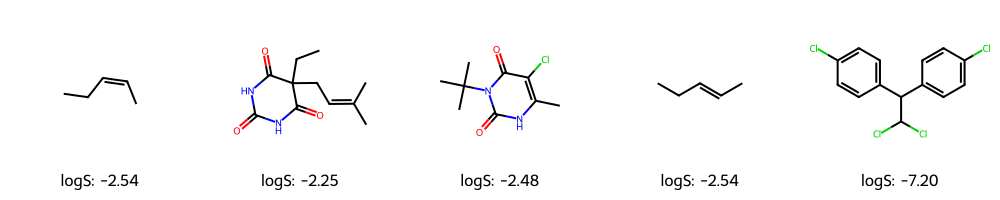

In [23]:
# Visualize 5 random molecules
sample = raw_csv.sample(5, random_state=42)
mols = [Chem.MolFromSmiles(s) for s in sample['smiles']]
legends = [f"logS: {s:.2f}" for s in sample['measured log solubility in mols per litre']]
img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200,200), legends=legends)
display(img)

### Distribution of Solubility Values

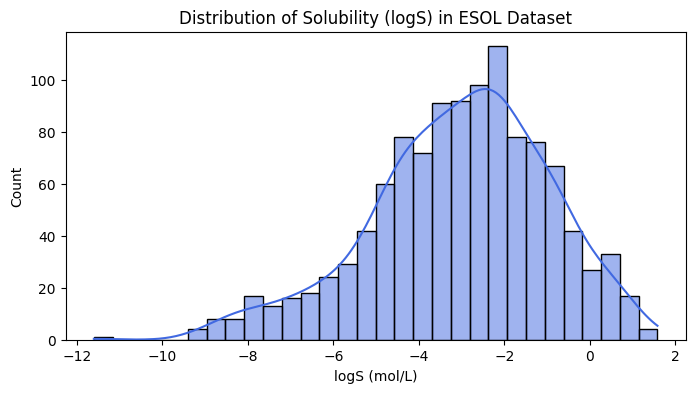

In [24]:
plt.figure(figsize=(8,4))
sns.histplot(raw_csv['measured log solubility in mols per litre'], bins=30, kde=True, color='royalblue')
plt.title('Distribution of Solubility (logS) in ESOL Dataset')
plt.xlabel('logS (mol/L)')
plt.ylabel('Count')
plt.show()

### Visualize Graph Structure of a Sample Molecule

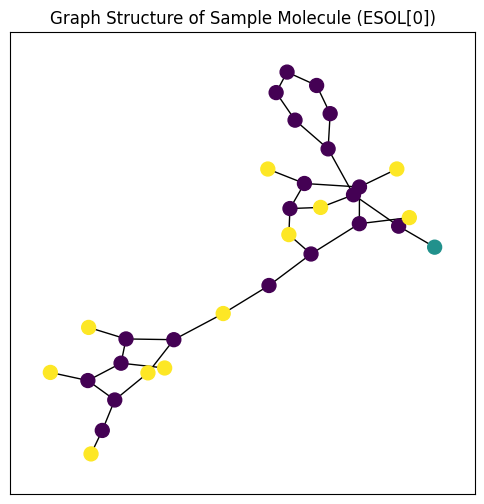

In [25]:
import networkx as nx
from torch_geometric.utils import to_networkx

sample_data = DATA[0]
G = to_networkx(sample_data, to_undirected=True)
plt.figure(figsize=(6,6))
nx.draw_networkx(G, node_size=100, node_color=sample_data.x[:,0], cmap='viridis', with_labels=False)
plt.title('Graph Structure of Sample Molecule (ESOL[0])')
plt.show()

### Implement a Graph Convolutional Neural Network

## 2. Build and Train the Graph Convolutional Network
We use a multi-layer GCN to learn molecular representations and predict solubility. The model leverages both node and edge features.

In [26]:
import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

EMBEDDING_DIM = 64

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        self.initial_conv = GCNConv( # The graph convolutional operator from the “Semi-supervised Classification with Graph Convolutional Networks” paper
          in_channels=DATA.num_features, # number of features per node of graph before transformation
          out_channels=EMBEDDING_DIM # number of features per node of graph after transformation
        )
        self.conv1 = GCNConv(EMBEDDING_DIM, EMBEDDING_DIM)
        self.conv2 = GCNConv(EMBEDDING_DIM, EMBEDDING_DIM)
        self.conv3 = GCNConv(EMBEDDING_DIM, EMBEDDING_DIM)
        self.out = Linear(
          in_features=EMBEDDING_DIM*2, # we stack the different global pooling aggregations below
          out_features=1
        )

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)
          
        # Global Pooling (stack different aggregations over nodes of graph)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

MODEL = GCN()
print(MODEL)
print("Number of parameters: ", sum(p.numel() for p in MODEL.parameters()))

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  13249


### Train the Graph Convolutional Network 

In [27]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

NUM_GRAPHS_PER_BATCH = 64

# Use GPU for training (if available)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [28]:
def train(model, data):
  model = model.to(DEVICE)

  loss_fn = torch.nn.MSELoss()

  optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

  data_size = len(data)
  train_loader = DataLoader(
    data[:int(data_size * 0.8)], 
    batch_size=NUM_GRAPHS_PER_BATCH, 
    shuffle=True
  )

  for batch in train_loader:
    # Use GPU
    batch.to(DEVICE)  
    # Reset gradients
    optimizer.zero_grad() 
    # Passing the node features and the edge info
    pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
    # Calculating the loss and gradients
    loss = loss_fn(pred, batch.y)     
    loss.backward()  
    # Update using the gradients
    optimizer.step()   
  return loss, embedding

def train_wrapper():
  print("Starting training...")
  losses = []
  for epoch in range(2000): 
      loss, h = train(MODEL, DATA)
      losses.append(loss)
      if epoch % 100 == 0: 
        print(f"Epoch {epoch} | Train Loss {loss}")
  return losses 

LOSSES = train_wrapper()

Starting training...
Epoch 0 | Train Loss 11.665947914123535
Epoch 100 | Train Loss 1.043239951133728
Epoch 100 | Train Loss 1.043239951133728
Epoch 200 | Train Loss 2.253338575363159
Epoch 200 | Train Loss 2.253338575363159
Epoch 300 | Train Loss 0.3085750937461853
Epoch 300 | Train Loss 0.3085750937461853
Epoch 400 | Train Loss 0.10700827091932297
Epoch 400 | Train Loss 0.10700827091932297
Epoch 500 | Train Loss 0.3353559970855713
Epoch 500 | Train Loss 0.3353559970855713
Epoch 600 | Train Loss 0.07884789258241653
Epoch 600 | Train Loss 0.07884789258241653
Epoch 700 | Train Loss 0.10973914712667465
Epoch 700 | Train Loss 0.10973914712667465
Epoch 800 | Train Loss 0.1625060886144638
Epoch 800 | Train Loss 0.1625060886144638
Epoch 900 | Train Loss 0.08274094760417938
Epoch 900 | Train Loss 0.08274094760417938
Epoch 1000 | Train Loss 0.03842971846461296
Epoch 1000 | Train Loss 0.03842971846461296
Epoch 1100 | Train Loss 0.11041035503149033
Epoch 1100 | Train Loss 0.11041035503149033
Epo

### Visualize training loss


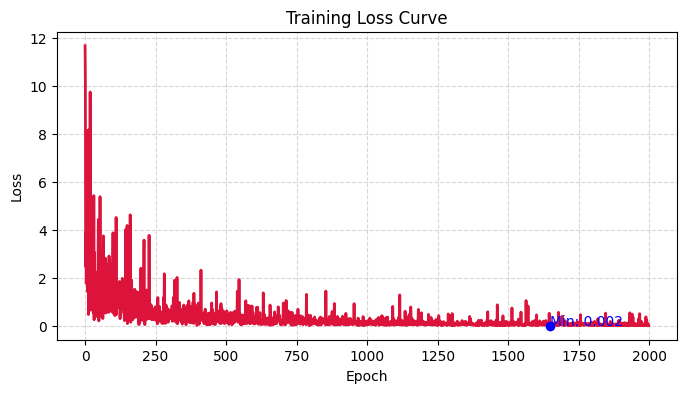

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_train_loss(): 
    losses_float = [float(loss.cpu().detach().numpy()) for loss in LOSSES] 
    loss_indices = range(len(losses_float))
    plt.figure(figsize=(8,4))
    ax = sns.lineplot(x=loss_indices, y=losses_float, color='crimson', linewidth=2)
    ax.set(xlabel='Epoch', ylabel='Loss', title='Training Loss Curve')
    plt.grid(True, linestyle='--', alpha=0.5)
    # Annotate minimum loss
    min_loss = min(losses_float)
    min_epoch = losses_float.index(min_loss)
    plt.scatter([min_epoch], [min_loss], color='blue', zorder=5)
    plt.text(min_epoch, min_loss, f"Min: {min_loss:.3f}", fontsize=10, color='blue')
    plt.show()

plot_train_loss()

### Predict solubility on test data and compare with true solubilities

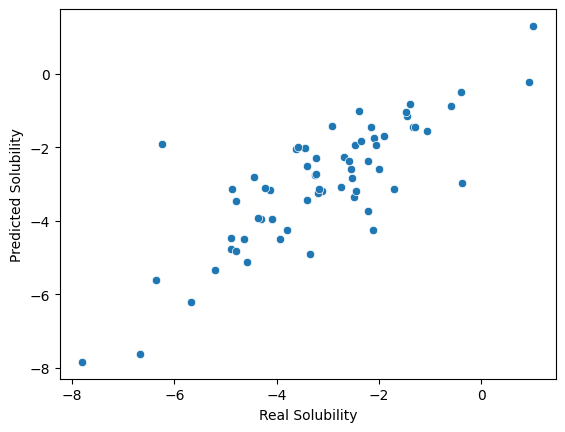

In [30]:
import pandas as pd 

def predict(model, data): 
  data_size = len(data)
  test_loader = DataLoader(
    data[int(data_size * 0.8):], 
    batch_size=NUM_GRAPHS_PER_BATCH, 
    shuffle=True
  )

  # Analyze the results for one batch
  test_batch = next(iter(test_loader))

  with torch.no_grad():
    test_batch.to(DEVICE)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()

  df["y_real"] = df["y_real"].apply(lambda row: row[0])
  df["y_pred"] = df["y_pred"].apply(lambda row: row[0])

  axes = sns.scatterplot(data=df, x="y_real", y="y_pred")
  axes.set_xlabel("Real Solubility")
  axes.set_ylabel("Predicted Solubility")

predict(MODEL, DATA)

## 4. Model Evaluation and Prediction Visualization
We evaluate the model on the test set and visualize predicted vs. true solubility values. We also compute error metrics for a quantitative assessment.

Test MAE: 0.663 | RMSE: 0.987 | R2: 0.778


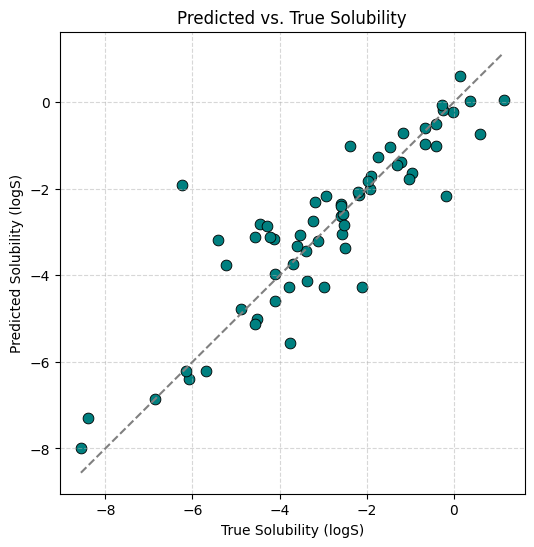

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def predict_and_evaluate(model, data): 
    data_size = len(data)
    test_loader = DataLoader(
        data[int(data_size * 0.8):], 
        batch_size=NUM_GRAPHS_PER_BATCH, 
        shuffle=True
    )
    test_batch = next(iter(test_loader))
    with torch.no_grad():
        test_batch.to(DEVICE)
        pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
        y_true = test_batch.y.cpu().numpy().flatten()
        y_pred = pred.cpu().numpy().flatten()
    # Metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"Test MAE: {mae:.3f} | RMSE: {rmse:.3f} | R2: {r2:.3f}")
    # Scatter plot
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=y_true, y=y_pred, color='teal', s=60, edgecolor='k')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], '--', color='gray')
    plt.xlabel('True Solubility (logS)')
    plt.ylabel('Predicted Solubility (logS)')
    plt.title('Predicted vs. True Solubility')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

predict_and_evaluate(MODEL, DATA)